Unit nonsense: x (vector) is used by dolfinx
Conversion to standard used in the related VPIC deck:

x\[0\] = z = direction along current sheet (x for matplotlib syntax)

x\[1\] = x = direction normal to current sheet (y for matplotlib syntax)

x\[2\] = y = invariant direction

In [1]:
import sys
import numpy as np
import numpy.random as rand

import ufl
from dolfinx import fem, io, mesh, plot
from ufl import ds, dx, grad, inner
from mpi4py import MPI
from petsc4py.PETSc import ScalarType

from datetime import datetime
import h5py


import matplotlib.pyplot as plt


In [2]:
def harris_dP_dA(B, d, x):
    """
    Calculates the RHS of the grad-shafranov eqn for a harris current sheet.
    
    Parameters:
    -----------
    
    B : array-like of floats
        The characteristic magnetic field. Non-constant for perturbed harris
    d : array-like of floats
        characteristic thickness of the magnetic field, varies for perturbed harris
    x : array-like of floats
        distance from x=0 line. Varies for perturbed harris.
        
    Returns:
    --------
    dP_dA: RHS of grad-shafranov for perturbed harris sheet.
    """
    
    dP_dA = -1*B/d*ufl.cosh(x/d)**(-2)
    return dP_dA

In [3]:
class FourierRand():
    """
    For fourier series with random coefficients. form a0/2 + sum_1^n(aj*cos(2*pi*j*x/L + phij))
    Uses ufl cosine and is therefore annoying
    
    Parameters:
    -----------
    L : float
        The size of the box (one period of the Fourier series)
    n : integer
        The number of terms desired in the fourier series, not counting the zero term.
    an_fn : function, default rand.default_rng().normal
        an_fn(**kwargs) the random number generator desired to generate an coordinates
    phin_fn : function, default rand.default_rng().uniform
        phin_fn(**phin_kwargs) the random number generator desired to generate phin
    an_kws : dict, default self.default_an_kws
        default keywords for the an random generator
    phin_kws : dict, default self.default_phin_kws
        default keywords for the an random generator
    
    Attributes:
    -----------
    default_an_kws : dict
        class attribute default keywords for an_fn
    default_phin_kws " dict
        class attribute default keywords for phin_fn
    an_kws : dict
        used keywords for an_fn
    phin_kws " dict
        default keywords for phin_fn
    an : array-like
        an fourier coefficients
    phin : array-like
        phin fourier coefficients
    """
    default_an_kws = {'loc':0.0, 'scale':0.1}  #size is forcibly set during init
    default_phin_kws = {'low':0.0, 'high': 2*np.pi}
    
    def __init__(self, L, n, an_fn=rand.default_rng().normal, phin_fn = rand.default_rng().uniform, 
                 an_kws=default_an_kws, phin_kws=default_phin_kws):
        self.L = L
        self.n = n
        if an_fn is not None and phin_fn is not None:
            self.an_kws = self.default_an_kws | an_kws | {'size':n+1}
            self.phin_kws = self.default_phin_kws | phin_kws | {'size':n}
            ''' set an and phin, ensuring the correct size for each '''
            self.an = an_fn(**self.an_kws)
            self.phin = phin_fn(**self.phin_kws)
        else:
            raise NotImplementedError("Fourier series with predetermined coefficients is not implemented yet.")
    
    def __call__(self, x):
        """ return the fourier series for a value or series of values
        
        Parameters:
        -----------
        x : float or array-like of floats
            the point(s) to evaluate the fourier series at
            
        Returns:
        --------
        frand : float or array-like of floats
            same shape as x. fourier series evaluated at x.
        """
        frand = self.an[0]/2
        
        for i, phij in enumerate(self.phin):
            j=i+1  # in the math phin starts with index 1
            frand += self.an[j]*ufl.cos(2*np.pi*j*x/self.L - phij)
        
        return frand


In [4]:
def bdy_finder_generator(bdy_bleft, bdy_tright):
    """ generator function so bdy_finder depends only on x (as dolfinx needs) but is
        flexible to defining what the boundaries actually are"""
    def bdy_finder(x):
       
        bdy = np.any([np.isclose(x[0], bdy_bleft[0]),
                            np.isclose(x[0], bdy_tright[0]),
                            np.isclose(x[1], bdy_bleft[1]),
                            np.isclose(x[1], bdy_tright[1])], axis=0)
        return bdy
    return bdy_finder

In [5]:
def harris_bc_gen(d_0, B_0):
    """Makes function to determine dirichlet boundary conditions for harris sheet for Ay """
    def harris_bc(x):
        bdy_val = d_0*B_0*np.log(np.cosh(x[1]/d_0))
        return bdy_val
    return harris_bc

def harris_bc_gen_p(d_0, B_0, mu_0):
    """Makes function to determine dirichlet boundary conditions for harris sheet for pressure
    should be p = integral(jy*Bx) with p->0 as y->inf"""
    def harris_bc_p(x):
        bdy_val = B_0**2/(2*mu_0)*np.cosh(x[1]/d_0)**(-2)
        return bdy_val
    return harris_bc_p

In [6]:
def mapping_generator_1d2d(z_list, x_list, bdy_bleft, bdy_tright, nsquares):
    """ Put the point-based format of the calculated quantities back into the grid format"""
    assert len(z_list) == (nsquares[0]+1)*(nsquares[1]+1), "Mesh dimensions and number of points do not match"
    
    z_vals = np.linspace(bdy_bleft[0], bdy_tright[0], nsquares[0]+1)
    x_vals = np.linspace(bdy_bleft[1], bdy_tright[1], nsquares[1]+1)
    
    mapping_vals = {}  # dictionary 'felt' better than list for some reason
    
    for i, (z_pt, x_pt) in enumerate(zip(z_list, x_list)):
        z_idx = np.asarray(np.isclose(z_vals,z_pt)).nonzero()  # no exact equals for floats just in case
        x_idx = np.asarray(np.isclose(x_vals,x_pt)).nonzero() # this returns tuple of arrays
        
        assert len(z_idx[0]) == len(x_idx[0]) == 1, f"Incorrect number of gridpoints found. Indices: {z_idx} {x_idx}"
        
        mapping_vals[i] = (z_idx[0][0], x_idx[0][0])
    
    def mapping_fn(listed_data):
        array_data = np.zeros((nsquares[0]+1, nsquares[1]+1))
        
        for idx in mapping_vals.keys():  # could use array operations somehow? idk. for loop for now.
            array_data[mapping_vals[idx]] = listed_data[idx]
        return array_data
    
    return mapping_fn

### Define some parameters and set up the mesh and function space

In [7]:
bdy_bleft = (-100.0, -25.0)
bdy_tright = (100.0, 25.0)
d_0 = 2.
B_0 = 1.  # magnetic field strength MUST BE 1 FOR PROPER FORCE BALANCE LATER B is scaled by wcewpe
mu_0 = 1.
gamma = 1.  # gamma=1 isothermal for our simulations
mime = 25.
nsquares = (2048, 512)
num_fourier = 15
num_fourier_width = 4

parameter_names=["bdy_bleft", "bdy_tright", "d_0", "B_0", "mu_0", "gamma", "mime", "nsquares"]

msh = mesh.create_rectangle(comm=MPI.COMM_WORLD,
                            points=(bdy_bleft, bdy_tright), n=nsquares,
                            cell_type=mesh.CellType.triangle,)

V = fem.FunctionSpace(msh, ("CG", 1))
facets = mesh.locate_entities_boundary(msh, dim=1,
                                       marker=bdy_finder_generator(bdy_bleft, bdy_tright))
dofs = fem.locate_dofs_topological(V=V, entity_dim=1, entities=facets)
bd_fn = harris_bc_gen(d_0, B_0)
har_bc = fem.Function(V, dtype=ScalarType)
har_bc.interpolate(bd_fn)
bc = fem.dirichletbc(value=har_bc, dofs=dofs)

### Perturb the RHS of the Harris poisson equation and numerically solve

In [8]:
for i in range(3):
    ay_fn = FourierRand(bdy_tright[0]-bdy_bleft[0], num_fourier, an_kws={'scale':2})
    b_fn = FourierRand(bdy_tright[0]-bdy_bleft[0], num_fourier, an_kws={'scale': B_0/20})

    x_noisy = lambda x: x[1] + ay_fn(x[0])
    b_noisy = lambda x: B_0  #+ b_fn(x[0])

    u = ufl.TrialFunction(V)
    v = ufl.TestFunction(V)
    x = ufl.SpatialCoordinate(msh)

    f = harris_dP_dA(b_noisy(x),d_0, x_noisy(x))  # defined as laplace A = -f
    a = inner(grad(u), grad(v)) * dx
    L = inner(f, v) * dx 
    problem = fem.petsc.LinearProblem(a, L, bcs=[bc], petsc_options={"ksp_type": "preonly", "pc_type": "lu"})
    soln = problem.solve()

    ### Calculate desired quantities from the solution (diffeq solve)

    # I love doing derivatives on unstructured meshes
    b_z = ufl.TrialFunction(V)
    a_z = inner(b_z, v) * dx
    L_z = inner(soln.dx(1), v) * dx
    prob_z = fem.petsc.LinearProblem(a_z, L_z, petsc_options={"ksp_type": "preonly", "pc_type": "lu"})
    soln_z = prob_z.solve()

    b_x = ufl.TrialFunction(V)
    a_x = inner(b_x, v) * dx
    L_x = inner(-1*soln.dx(0), v) * dx
    prob_x = fem.petsc.LinearProblem(a_x, L_x, petsc_options={"ksp_type": "preonly", "pc_type": "lu"})
    soln_x = prob_x.solve()

    j_y = ufl.TrialFunction(V)
    a_j = inner(j_y, v) * dx
    L_j = inner(1/mu_0*(soln_x.dx(0) - soln_z.dx(1)), v) * dx
    prob_j = fem.petsc.LinearProblem(a_j, L_j, petsc_options={"ksp_type": "preonly", "pc_type": "lu"})
    soln_j = prob_j.solve()

    p = ufl.TrialFunction(V)
    # set ideal harris bcs
    bd_fn_p = harris_bc_gen_p(d_0, B_0, mu_0)
    har_bc_p = fem.Function(V, dtype=ScalarType)
    har_bc_p.interpolate(bd_fn_p)
    bc_p = fem.dirichletbc(value=har_bc_p, dofs=dofs)
    a_p = inner(ufl.grad(p), ufl.grad(v)) * dx
    L_p = inner((soln_j*soln_x).dx(0)-(soln_j*soln_z).dx(1),v) * dx
    prob_p = fem.petsc.LinearProblem(a_p, L_p, bcs=[bc_p])
    soln_p = prob_p.solve()

    # solve for pressure from equib eqn
    # use pressure and adiabatic gas const to find density, then temperature (check how normalized units work)
    # do we need to change frames?


    # do we need to add flow to switch frame for the kinetic sim?
    z_pts = msh.geometry.x[:,0]
    x_pts = msh.geometry.x[:,1]

    Ay_real = soln.x.array.real
    bz_real = soln_z.x.array.real
    bx_real = soln_x.x.array.real
    jy_real = soln_j.x.array.real
    p_real = soln_p.x.array.real
    p_real = p_real - 1.001*min(0, np.min(p_real))  # enforce nonnegative pressure

    ### Calculate desired quantities from the solution (algebraic)

    n_real = p_real**(1/gamma)/np.max(p_real**(1/gamma))*mime**1.5  # max density is mime^(3/2) to be 1 when converted to de
    t_real = p_real/n_real
    print(max(np.sqrt(t_real)))

    by_real = np.full_like(bx_real, 0.)  # zero guide field for now. Can change to another constant
    jz_real = np.zeros_like(jy_real)
    jx_real = np.zeros_like(jy_real)

    ### Wrangle everything back into a 2d format somehow rather than point by point


    mapping_fn = mapping_generator_1d2d(z_pts, x_pts, bdy_bleft, bdy_tright, nsquares)
    z_2d = mapping_fn(z_pts)  # shaped like a numpy meshgrid (ij form)
    x_2d = mapping_fn(x_pts)
    ay_2d = mapping_fn(Ay_real)
    bz_2d = mapping_fn(bz_real)
    bx_2d = mapping_fn(bx_real)
    by_2d = mapping_fn(by_real)
    jz_2d = mapping_fn(jz_real)
    jx_2d = mapping_fn(jx_real)
    jy_2d = mapping_fn(jy_real)
    p_2d = mapping_fn(p_real)
    n_2d = mapping_fn(n_real)
    t_2d = mapping_fn(t_real)

    ## Dump to a file
    suffix = datetime.now().strftime("%Y%m%d_%H%M%S")

    with h5py.File("grad_shaf_outputs/perturbation_set_bigvar/perturbed_harris_" + suffix + ".h5", 'w') as f:
        # starting parameters as attributes:
        for p in parameter_names:
            f.attrs.create(p, locals()[p])
        # Fourier coefficients and parameters:
        f.attrs.create("ay_perturb_params_an", str(ay_fn.an_kws))
        f.attrs.create("ay_perturb_params_phin", str(ay_fn.phin_kws))
        f.attrs.create("ay_perturb_an", str(ay_fn.an))
        f.attrs.create("ay_perturb_phin", str(ay_fn.phin))
        # f.attrs.create("b0_perturb_params_an", str(b_fn.an_kws))
        # f.attrs.create("b0_perturb_params_phin", str(b_fn.phin_kws))
        # f.attrs.create("b0_perturb_an", str(b_fn.an))
        # f.attrs.create("b0_perturb_phin", str(b_fn.phin))
        # The actual data:
        z_dset = f.create_dataset("z_mgrid", data=z_2d); z_dset.attrs.create("desc", "z location in meshgrid (ij) form")
        x_dset = f.create_dataset("x_mgrid", data=x_2d); x_dset.attrs.create("desc", "x location in meshgrid (ij) form")
        ay_dset = f.create_dataset("ay", data=ay_2d); ay_dset.attrs.create("desc", "y component of vector potential")
        bz_dset = f.create_dataset("bz", data=bz_2d); bz_dset.attrs.create("desc", "z component of magnetic field")
        bx_dset = f.create_dataset("bx", data=bx_2d); bx_dset.attrs.create("desc", "x component of magnetic field")
        by_dset = f.create_dataset("by", data=by_2d); by_dset.attrs.create("desc", "y component of magnetic field")
        jz_dset = f.create_dataset("jz", data=jz_2d); jz_dset.attrs.create("desc", "z component of current density")
        jx_dset = f.create_dataset("jx", data=jx_2d); jx_dset.attrs.create("desc", "x component of current density")
        jy_dset = f.create_dataset("jy", data=jy_2d); jy_dset.attrs.create("desc", "y component of current density")
        p_dset = f.create_dataset("p", data=p_2d); p_dset.attrs.create("desc", "pressure")
        n_dset = f.create_dataset("n", data=n_2d); p_dset.attrs.create("desc", "density")
        t_dset = f.create_dataset("t", data=t_2d); p_dset.attrs.create("desc", "temperature")
        # misc info I think is useful
        f.attrs.create("geometry", "Current sheet approximately in z-y plane (x out of plane direction). y is the invariant direction.")

    ### Plot to visualize


    fig,ax = plt.subplots(5,figsize=(8,20))
    levels = 100
    ylims = (-25,25)

    ay_plt = ax[0].contour(z_2d, x_2d, ay_2d, levels=levels)
    ax[0].set(title=f"Numerical solution $A_y$")
    fig.colorbar(ay_plt, ax=ax[0])
    ax[0].set_ylim(*ylims)

    bz_plt = ax[1].contour(z_2d, x_2d, bz_2d, levels=levels)
    ax[1].set(title=f"Numerical solution $B_z$")
    fig.colorbar(bz_plt, ax=ax[1])
    ax[1].set_ylim(*ylims)

    jy2d_plt = ax[2].contour(z_2d, x_2d, jy_2d, levels=levels)
    ax[2].set(title=f"Numerical solution $j_y$ from gridded data")
    fig.colorbar(jy2d_plt, ax=ax[2])
    ax[2].set_ylim(*ylims)

    p_plt = ax[3].contour(z_2d, x_2d, p_2d, levels=levels)
    ax[3].set(title=f"Numerical solution $p$")
    fig.colorbar(p_plt, ax=ax[3])
    ax[3].set_ylim(*ylims)

    n_plt = ax[4].contour(z_2d, x_2d, n_2d, levels=levels)
    ax[4].set(title=f"Numerical solution $n$")
    fig.colorbar(n_plt, ax=ax[4])
    ax[4].set_ylim(*ylims)

    # n_plt = ax[4].tricontour(msh.geometry.x[:,0], msh.geometry.x[:,1], n_real, levels=levels)
    # ax[4].set(title=f"Numerical solution $n$")
    # fig.colorbar(n_plt, ax=ax[4])
    # ax[4].set_ylim(*ylims)

    fig.tight_layout()
    fig.savefig("grad_shaf_outputs/perturbation_set_bigvar/perturbed_image_" + suffix + ".svg")
    plt.close(fig='all')


0.09035924008702724
0.0869845857857948
0.09424553957091991


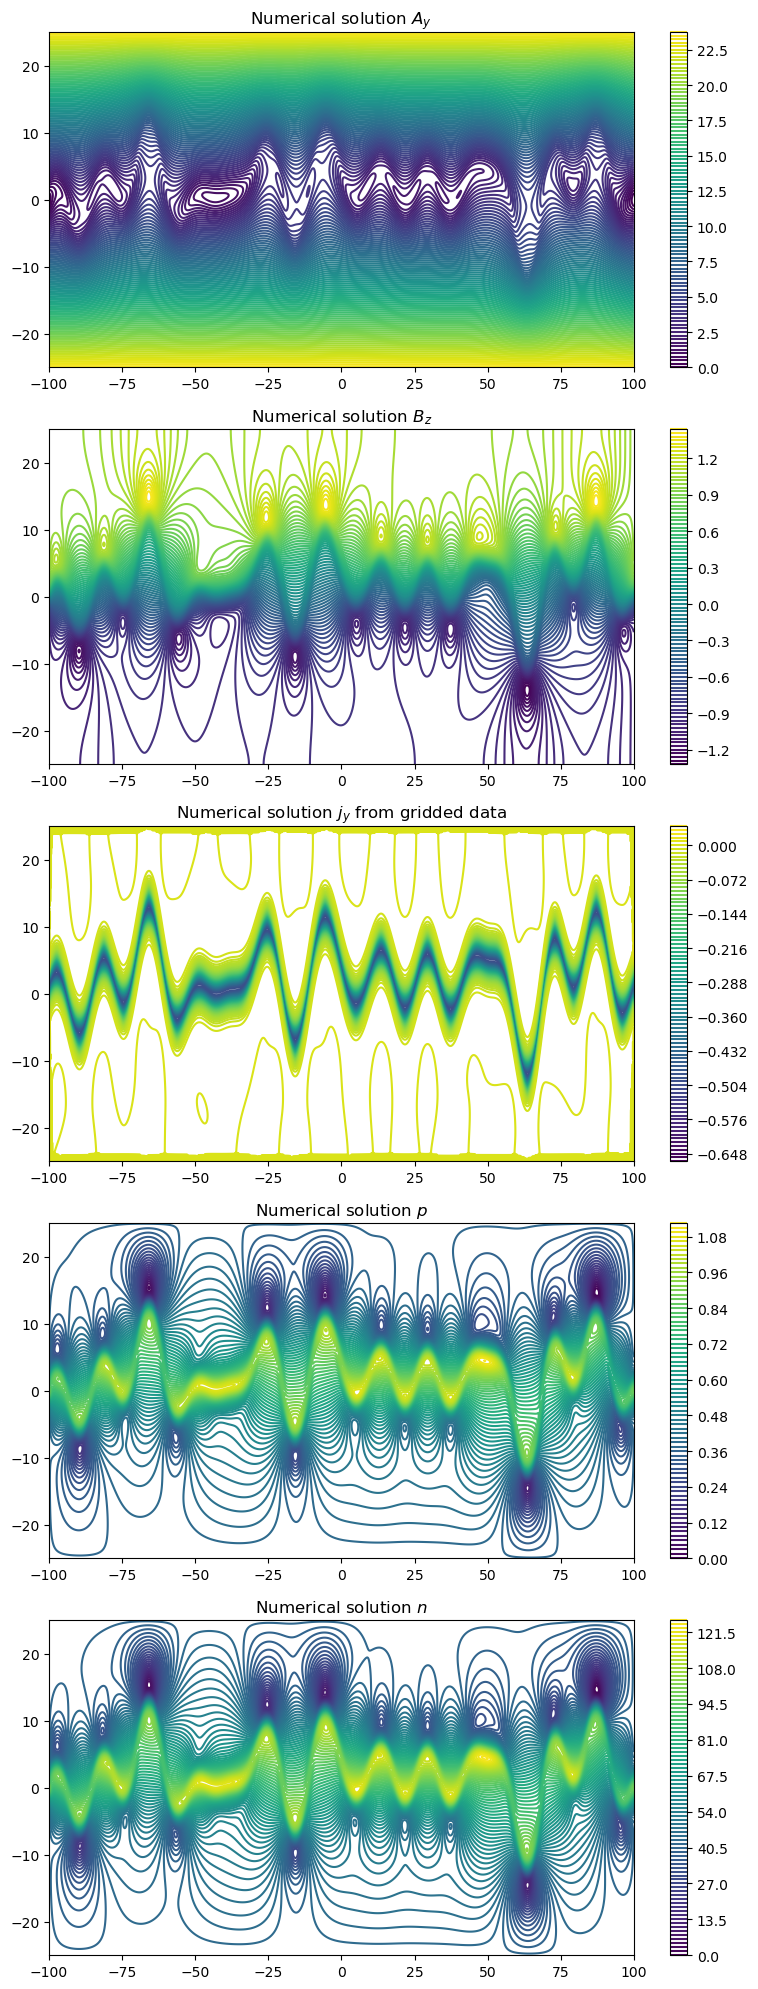

In [9]:
    fig,ax = plt.subplots(5,figsize=(8,20))
    levels = 100
    ylims = (-25,25)

    ay_plt = ax[0].contour(z_2d, x_2d, ay_2d, levels=levels)
    ax[0].set(title=f"Numerical solution $A_y$")
    fig.colorbar(ay_plt, ax=ax[0])
    ax[0].set_ylim(*ylims)

    bz_plt = ax[1].contour(z_2d, x_2d, bz_2d, levels=levels)
    ax[1].set(title=f"Numerical solution $B_z$")
    fig.colorbar(bz_plt, ax=ax[1])
    ax[1].set_ylim(*ylims)

    jy2d_plt = ax[2].contour(z_2d, x_2d, jy_2d, levels=levels)
    ax[2].set(title=f"Numerical solution $j_y$ from gridded data")
    fig.colorbar(jy2d_plt, ax=ax[2])
    ax[2].set_ylim(*ylims)

    p_plt = ax[3].contour(z_2d, x_2d, p_2d, levels=levels)
    ax[3].set(title=f"Numerical solution $p$")
    fig.colorbar(p_plt, ax=ax[3])
    ax[3].set_ylim(*ylims)

    n_plt = ax[4].contour(z_2d, x_2d, n_2d, levels=levels)
    ax[4].set(title=f"Numerical solution $n$")
    fig.colorbar(n_plt, ax=ax[4])
    ax[4].set_ylim(*ylims)

    # n_plt = ax[4].tricontour(msh.geometry.x[:,0], msh.geometry.x[:,1], n_real, levels=levels)
    # ax[4].set(title=f"Numerical solution $n$")
    # fig.colorbar(n_plt, ax=ax[4])
    # ax[4].set_ylim(*ylims)

    fig.tight_layout()
    # fig.savefig("grad_shaf_outputs/testing/perturbed_image_" + suffix + ".svg")
    # plt.close(fig='all')
    plt.show()
